In [1]:
from os import getenv
import boto3
import pandas as pd
import io
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv

In [2]:
# AWS S3 Details
load_dotenv()
# AWS S3 Details
AWS_ACCESS_KEY_ID = getenv('AWS_ACCESS_KEY_ID')
AWS_SECRET_ACCESS_KEY = getenv('AWS_SECRET_ACCESS_KEY')
BUCKET_NAME = ('S3_BUCKET')
FOLDER_NAME = ('S3_FOLDER')

In [3]:
def read_from_s3(filename):
    """
    Read the CSV from Amazon S3.
    """
    s3 = boto3.client(
        's3',
        aws_access_key_id=AWS_ACCESS_KEY_ID,
        aws_secret_access_key=AWS_SECRET_ACCESS_KEY
    )
    try:
        obj = s3.get_object(Bucket=BUCKET_NAME, Key=f"{FOLDER_NAME}/raw_data/{filename}")
        return pd.read_csv(io.BytesIO(obj['Body'].read()))
    except s3.exceptions.NoSuchKey:
        print("File not found in S3")
        return pd.DataFrame()

# Load the data
filename = '3hour_interval_weather_data.csv'
df = read_from_s3(filename)

In [4]:
# Convert datetime column to datetime type
df['datetime'] = pd.to_datetime(df['datetime'])

In [5]:
# Extract date and time from datetime
df['date'] = df['datetime'].dt.date
df['time'] = df['datetime'].dt.time

In [6]:
# Calculate additional features
df['temp_range'] = df['max_temperature'] - df['min_temperature']

In [7]:
# Convert pressure and humidity columns to float type
df['pressure'] = df['pressure'].astype(float)
df['humidity'] = df['humidity'].astype(float)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   city_name            360 non-null    object        
 1   datetime             360 non-null    datetime64[ns]
 2   temperature          360 non-null    float64       
 3   min_temperature      360 non-null    float64       
 4   max_temperature      360 non-null    float64       
 5   pressure             360 non-null    float64       
 6   humidity             360 non-null    float64       
 7   wind_speed           360 non-null    float64       
 8   weather_description  360 non-null    object        
 9   cloudiness           360 non-null    int64         
 10  precipitation        360 non-null    float64       
 11  date                 360 non-null    object        
 12  time                 360 non-null    object        
 13  temp_range           360 non-null  

In [9]:
df.head()

,city_name,datetime,temperature,min_temperature,max_temperature,pressure,humidity,wind_speed,weather_description,cloudiness,precipitation,date,time,temp_range
0,Accra,2024-06-12 12:00:00,29.23,28.08,29.23,1013.0,74.0,5.01,light rain,75,0.31,2024-06-12,12:00:00,1.15
1,Accra,2024-06-12 15:00:00,28.89,28.22,28.89,1012.0,73.0,5.36,light rain,72,0.35,2024-06-12,15:00:00,0.67
2,Accra,2024-06-12 18:00:00,27.87,27.19,27.87,1012.0,76.0,5.12,broken clouds,81,0.00,2024-06-12,18:00:00,0.68
3,Accra,2024-06-12 21:00:00,26.69,26.69,26.69,1014.0,80.0,4.70,overcast clouds,98,0.00,2024-06-12,21:00:00,0.00
4,Accra,2024-06-13 00:00:00,26.38,26.38,26.38,1013.0,80.0,3.83,overcast clouds,98,0.00,2024-06-13,00:00:00,0.00


In [10]:
# Save the transformed data to a CSV file locally
transformed_csv_filename = 'transformed_weather_data.csv'
df.to_csv(transformed_csv_filename, index=False)
print(f"Transformed data saved to {transformed_csv_filename} locally.")

Transformed data saved to transformed_weather_data.csv locally.


## Making Visualizations with Matplotlib

### Line plot of temperature over time for each city

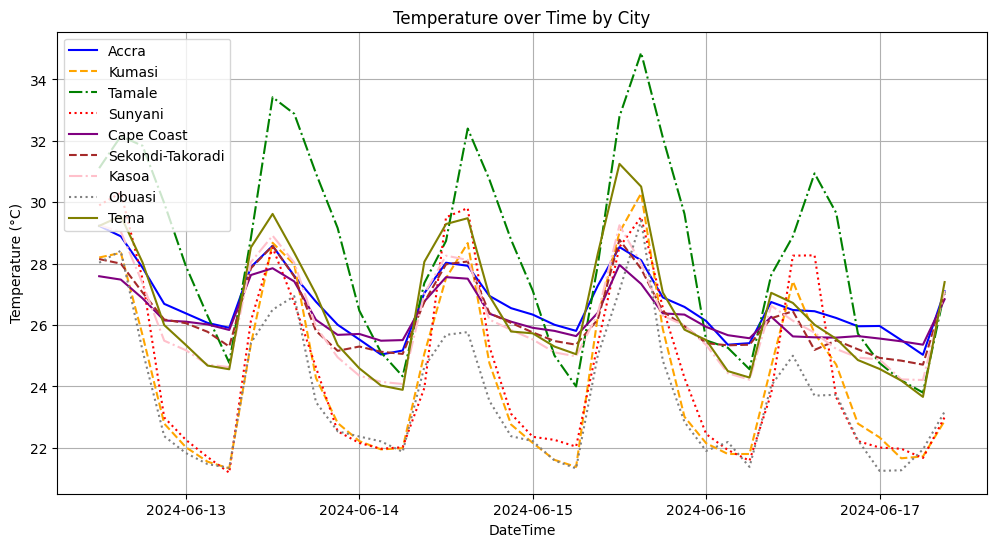

In [11]:
plt.figure(figsize=(12, 6))
styles = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-']
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive']
for i, city in enumerate(df['city_name'].unique()):
    city_data = df[df['city_name'] == city]
    plt.plot(city_data['datetime'], city_data['temperature'], label=city, linestyle=styles[i], color=colors[i])
plt.xlabel('DateTime')
plt.ylabel('Temperature (°C)')
plt.title('Temperature over Time by City')
plt.legend(loc='upper left')
plt.grid(True)
plt.savefig('line_plot.png')
plt.show()

### Histogram of temperature distribution for all cities

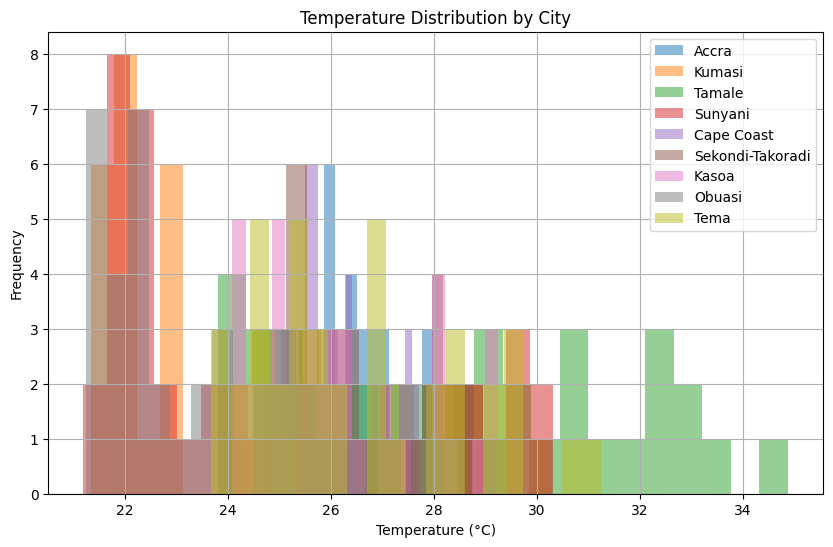

In [12]:
plt.figure(figsize=(10, 6))
for city in df['city_name'].unique():
    city_data = df[df['city_name'] == city]
    plt.hist(city_data['temperature'], bins=20, alpha=0.5, label=city)
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.title('Temperature Distribution by City')
plt.legend()
plt.grid(True)
plt.savefig('histogram.png')
plt.show()

### Scatter Plot

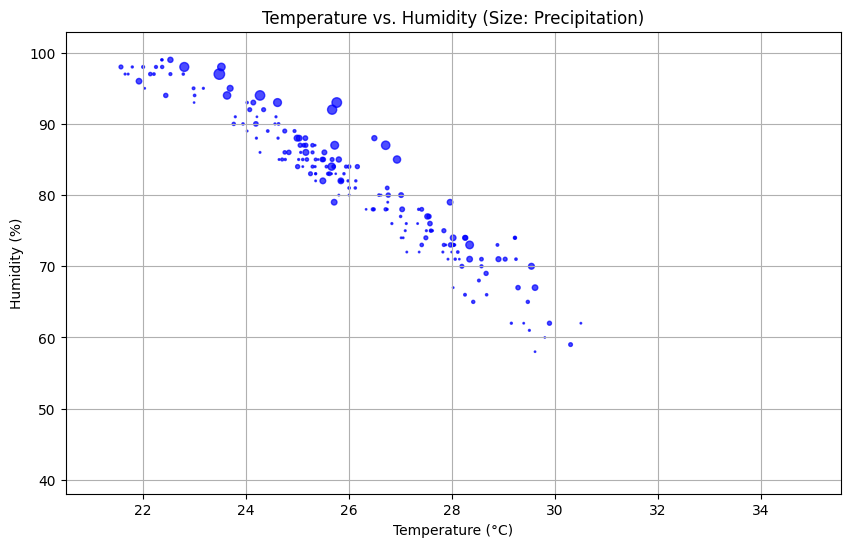

In [13]:
plt.figure(figsize=(10, 6))
plt.scatter(df['temperature'], df['humidity'], s=df['precipitation']*10, alpha=0.7, c='blue')
plt.xlabel('Temperature (°C)')
plt.ylabel('Humidity (%)')
plt.title('Temperature vs. Humidity (Size: Precipitation)')
plt.grid(True)
plt.savefig('scatter_plot.png')
plt.show()

### Temperature distribution by City and Time

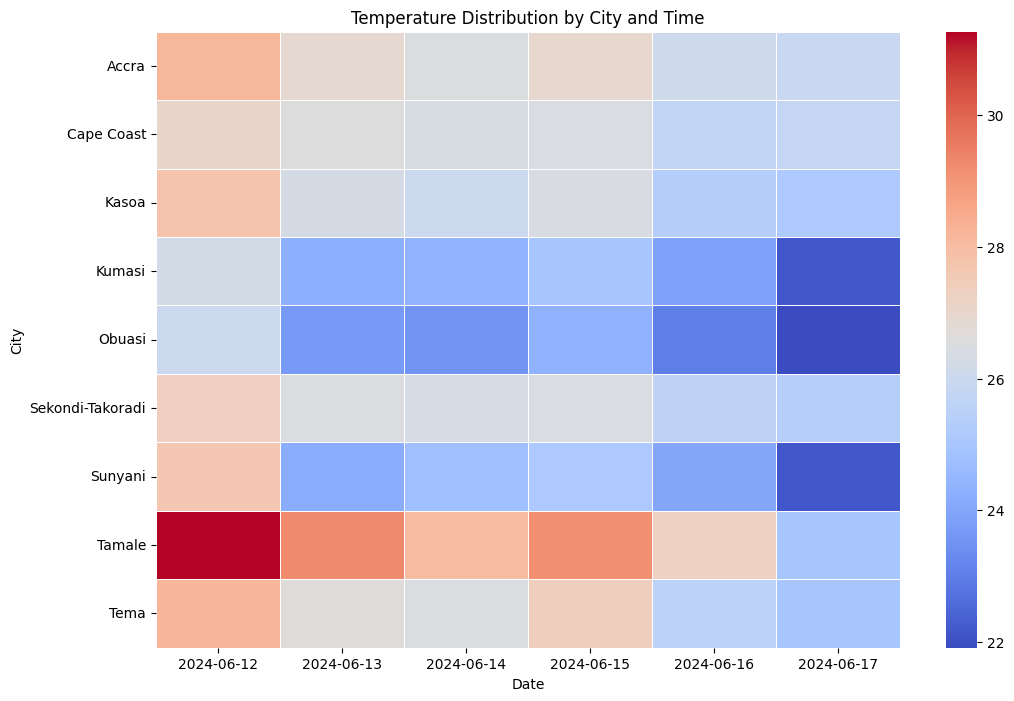

In [14]:
# Pivot the DataFrame to prepare data for heatmap
heatmap_data = df.pivot_table(index='city_name', columns='date', values='temperature', aggfunc='mean')

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='coolwarm', linewidths=0.5)
plt.title('Temperature Distribution by City and Time')
plt.xlabel('Date')
plt.ylabel('City')
plt.savefig('Heat_map.png')
plt.show()

### Pie Chart

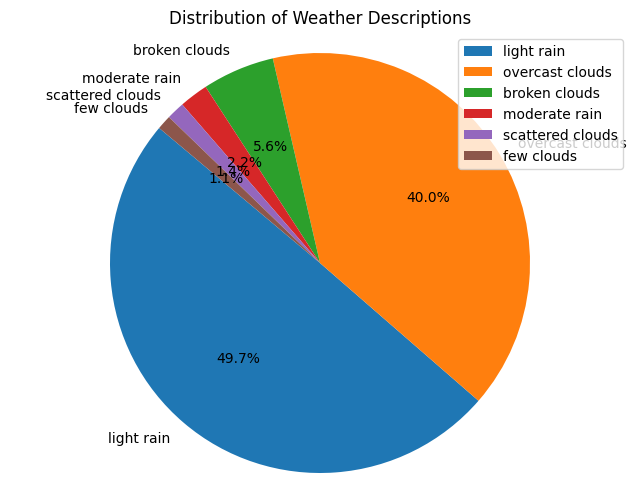

In [15]:
weather_description_counts = df['weather_description'].value_counts()
explode = [0.1 if desc == 'Rain' else 0 for desc in weather_description_counts.index]  # Explode 'Rain' slice
plt.figure(figsize=(8, 6))
plt.pie(weather_description_counts, labels=weather_description_counts.index, autopct='%1.1f%%', startangle=140, explode=explode)
plt.title('Distribution of Weather Descriptions')
plt.axis('equal')
plt.legend(weather_description_counts.index, loc='upper right')
plt.savefig('pie_chart.png')
plt.show()

### Box Plot

<Figure size 1000x600 with 0 Axes>

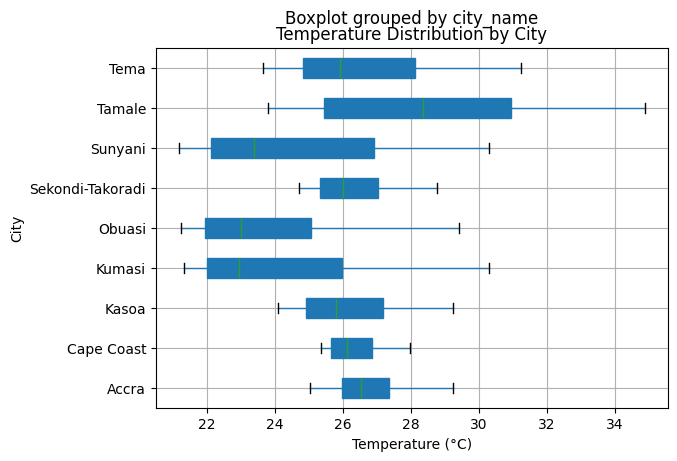

In [16]:
plt.figure(figsize=(10, 6))
df.boxplot(column='temperature', by='city_name', vert=False, patch_artist=True)
plt.xlabel('Temperature (°C)')
plt.ylabel('City')
plt.title('Temperature Distribution by City')
plt.savefig('box_plot.png')
plt.show()

### A Dashboard of all diagrams

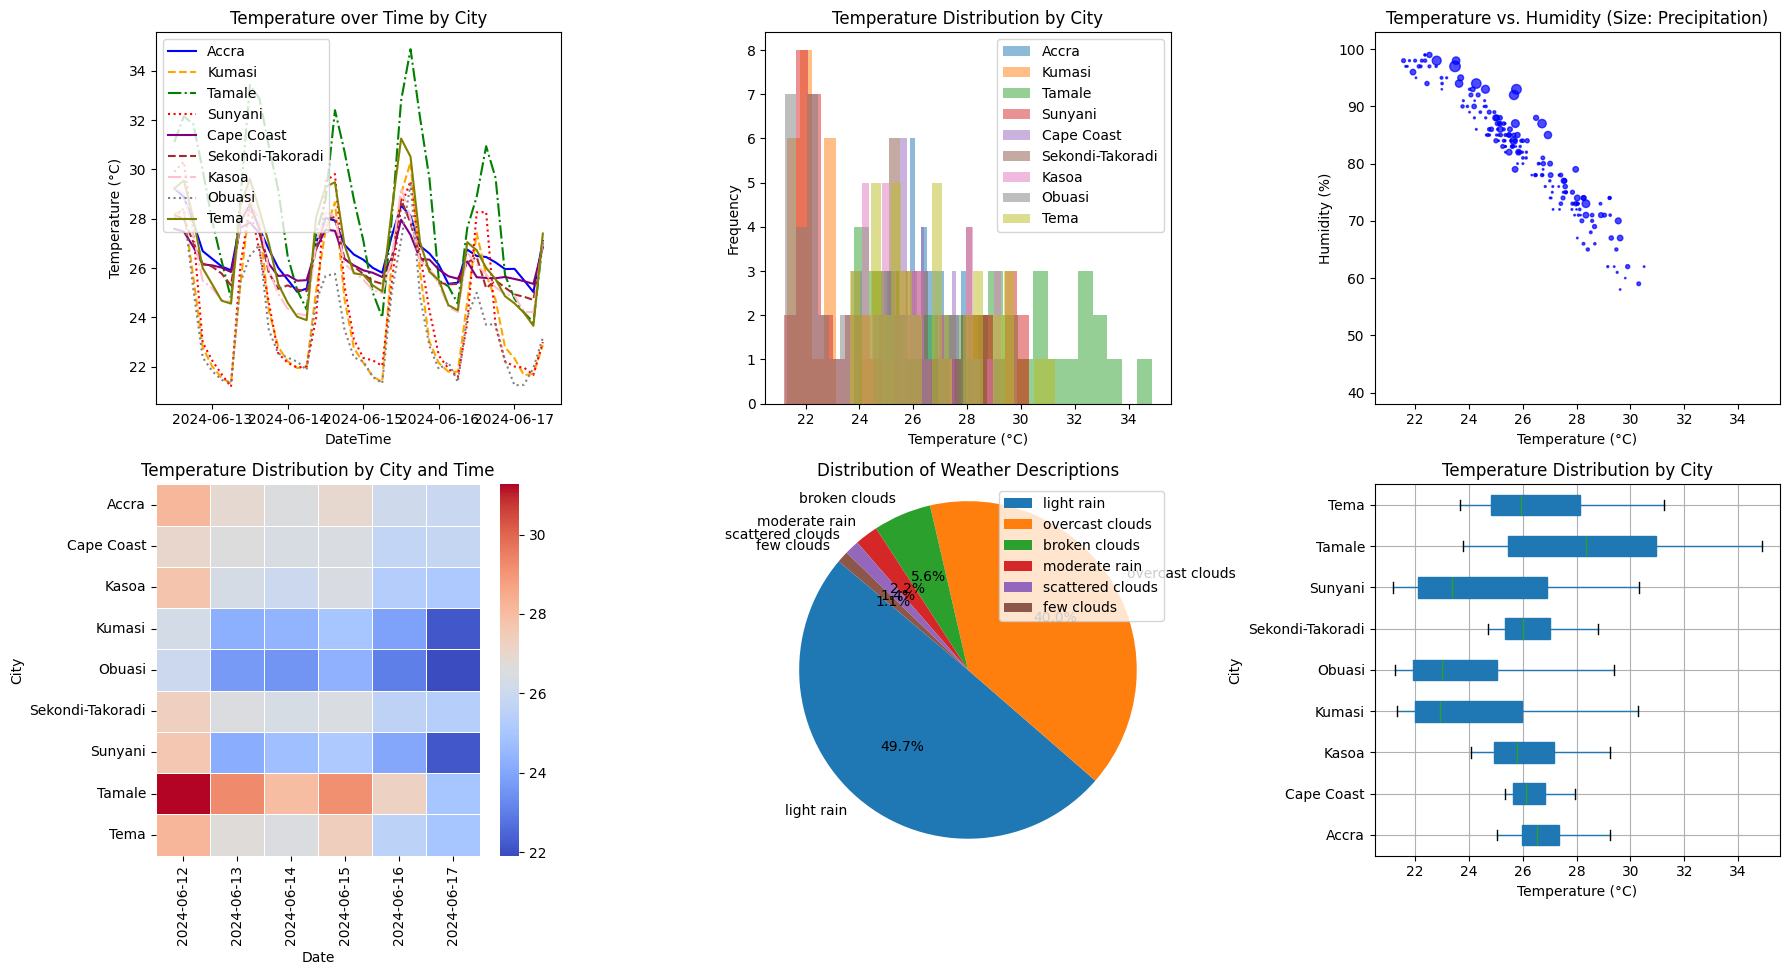

In [18]:
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

# PLOT 1
styles = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-']
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive']
for i, city in enumerate(df['city_name'].unique()):
    city_data = df[df['city_name'] == city]
    axs[0, 0].plot(city_data['datetime'], city_data['temperature'], label=city, linestyle=styles[i], color=colors[i])
axs[0, 0].set_xlabel('DateTime')
axs[0, 0].set_ylabel('Temperature (°C)')
axs[0, 0].set_title('Temperature over Time by City')
axs[0, 0].legend(loc='upper left')

#PLOT 2
for city in df['city_name'].unique():
    city_data = df[df['city_name'] == city]
    axs[0, 1].hist(city_data['temperature'], bins=20, alpha=0.5, label=city)
axs[0, 1].set_xlabel('Temperature (°C)')
axs[0, 1].set_ylabel('Frequency')
axs[0, 1].set_title('Temperature Distribution by City')
axs[0, 1].legend()

# PLOT 3
axs[0, 2].scatter(df['temperature'], df['humidity'], s=df['precipitation']*10, alpha=0.7, c='blue')
axs[0, 2].set_xlabel('Temperature (°C)')
axs[0, 2].set_ylabel('Humidity (%)')
axs[0, 2].set_title('Temperature vs. Humidity (Size: Precipitation)')

# PLOT 4
# Pivot the DataFrame to prepare data for heatmap
heatmap_data = df.pivot_table(index='city_name', columns='date', values='temperature', aggfunc='mean')

# Create the heatmap
sns.heatmap(heatmap_data, cmap='coolwarm', linewidths=0.5, ax=axs[1, 0])
axs[1, 0].set_title('Temperature Distribution by City and Time')
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('City')

# PLOT 5
weather_description_counts = df['weather_description'].value_counts()
explode = [0.1 if desc == 'Rain' else 0 for desc in weather_description_counts.index]  # Explode 'Rain' slice
axs[1, 1].pie(weather_description_counts, labels=weather_description_counts.index, autopct='%1.1f%%', startangle=140, explode=explode)
axs[1, 1].set_title('Distribution of Weather Descriptions')
axs[1, 1].axis('equal')
axs[1, 1].legend(weather_description_counts.index, loc='upper right')

# PLOT 6
df.boxplot(column='temperature', by='city_name', vert=False, patch_artist=True, ax=axs[1, 2])
axs[1, 2].set_xlabel('Temperature (°C)')
axs[1, 2].set_ylabel('City')
axs[1, 2].set_title('Temperature Distribution by City')
plt.suptitle('')


plt.tight_layout()
plt.savefig('dashboard.png')
plt.show()